In [95]:
'''
important finding: In the hirex data only every fourth image corresponds to a spectrum. It records for the maximum rate.
First spectrum seems to be at index 20
drop first spectrum, the first agipd image in the raw data is used as a dark and dropped when moving to the calibrated version
'''
import sys
sys.path.append('/gpfs/exfel/exp/SPB/202501/p006933/usr/Software/')
from analysistools import data_helper as dh
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
from generatorpipeline.generatorpipeline import generatorpipeline as gp
from generatorpipeline.generatorpipeline import accumulators
import extra_data as ex
import pandas as pd

trains_dh=dh.train_source(run=8)
hist=dh.Histogrammer(bins=100, range=(0,500))

def mask_spectrum(line):
    mask=np.ones(len(line), dtype=bool)
    mask[201:208]=0 #part of old mask
    mask[317]=0
    mask[511]=0
    mask[673]=0
    mask[1121]=0
    mask[1234]=0
    mask[1236]=0
    mask[1282:1284]=0 #part of old mask
    mask[1455]=0
    mask[1808:1824]=0 #part of old mask
    mask[2304]=0
    return mask

default_mask=mask_spectrum(np.ones(2560))

def check_for_spectrum(line, mask=default_mask):
    histogram=hist(line[mask])
    hist_mask=hist.centers()>50
    return np.sum(histogram[hist_mask])> 10

spectrum_flag_df=pd.read_csv('spectrum_flag_run8.csv')


In [96]:
def autocorrelate(spectrum):
    spectrum2=spectrum[~np.isnan(spectrum)]
    return scipy.signal.correlate(spectrum2, spectrum2, mode="full", method='fft')


@gp.pipeline(20)
def mean_autocorrelation_train(train):
    skipped_first=False
    auto=accumulators.Mean()
    data=train[1]
    spec_data=data[dh.det['hirex']]['data.adc']
    for index in range(np.shape(spec_data)[0]):
        curr_spec=spec_data[index,:]
        if spectrum_flag_df['flag'][index]:
            auto.accumulate(autocorrelate(curr_spec))
    return auto

def mean_autocorrelation_run(run=8):
    t0=time.time()
    trains=dh.spec_source(run)
    auto_trains=mean_autocorrelation_train(trains)
    acc=accumulators.Mean()
    n=0
    for spec_auto in auto_trains:
        acc.accumulate(spec_auto)
    t1=time.time()
    print(t1-t0)
    return acc.value
    

99.87% of the data of run 35 is used!
81.69% of the data of run 36 is used!
98.37% of the data of run 37 is used!
99.90% of the data of run 38 is used!
99.93% of the data of run 39 is used!
99.90% of the data of run 40 is used!
99.93% of the data of run 41 is used!
99.90% of the data of run 42 is used!
99.93% of the data of run 43 is used!
99.90% of the data of run 44 is used!
98.37% of the data of run 45 is used!
99.93% of the data of run 46 is used!
99.93% of the data of run 47 is used!
99.83% of the data of run 48 is used!
98.53% of the data of run 49 is used!
99.33% of the data of run 50 is used!
99.93% of the data of run 51 is used!
99.87% of the data of run 52 is used!
99.93% of the data of run 53 is used!
99.93% of the data of run 54 is used!
99.87% of the data of run 55 is used!
99.93% of the data of run 56 is used!
99.93% of the data of run 57 is used!
99.90% of the data of run 58 is used!
hitfinder not detected
99.90% of the data of run 59 is used!
hitfinder not detected
91.5

Skipping file CORR-R0061-AGIPD15-S00002.h5
  (error was: INDEX/trainId dataset not found)
Skipping file CORR-R0061-AGIPD13-S00002.h5
  (error was: INDEX/trainId dataset not found)


hitfinder not detected
56.69% of the data of run 61 is used!


Skipping file CORR-R0061-AGIPD13-S00002.h5
  (error was: INDEX/trainId dataset not found)
Skipping file CORR-R0061-AGIPD08-S00005.h5
  (error was: Unable to synchronously open file (bad object header version number))
Skipping file CORR-R0061-AGIPD09-S00005.h5
  (error was: Unable to synchronously open file (bad object header version number))
Skipping file CORR-R0061-AGIPD13-S00002.h5
  (error was: INDEX/trainId dataset not found)
Skipping file CORR-R0061-AGIPD10-S00005.h5
  (error was: Unable to synchronously open file (bad object header version number))
Skipping file CORR-R0061-AGIPD11-S00005.h5
  (error was: Unable to synchronously open file (bad object header version number))


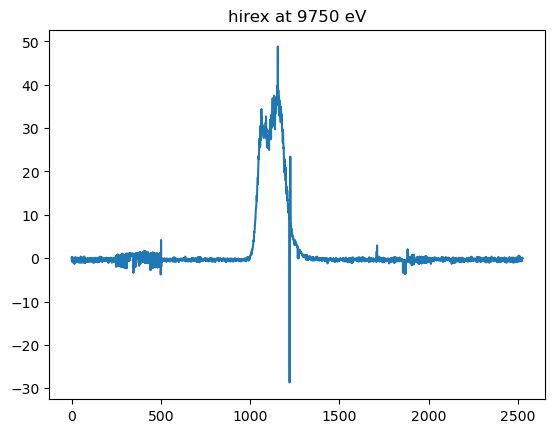

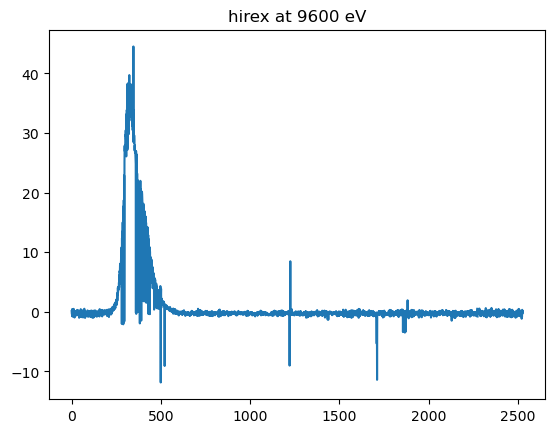

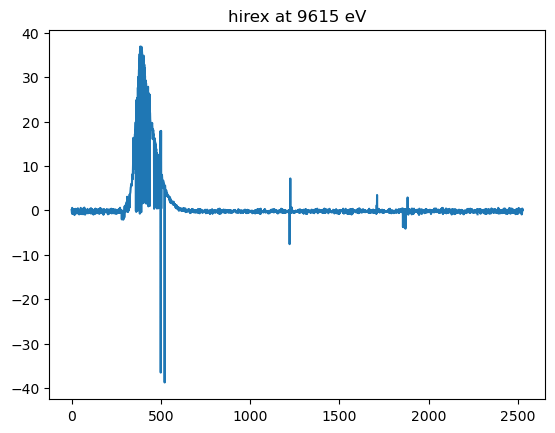

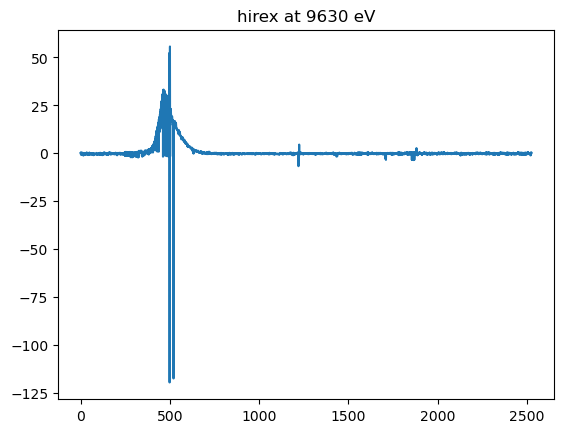

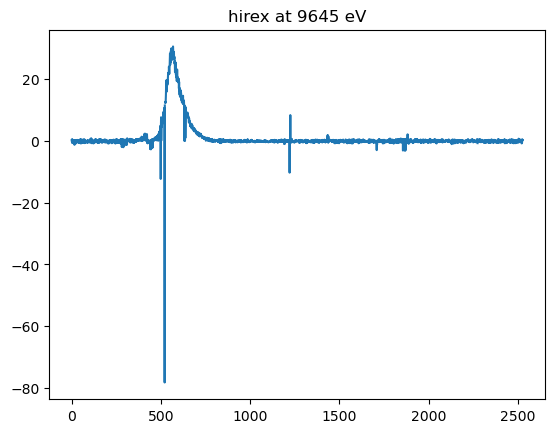

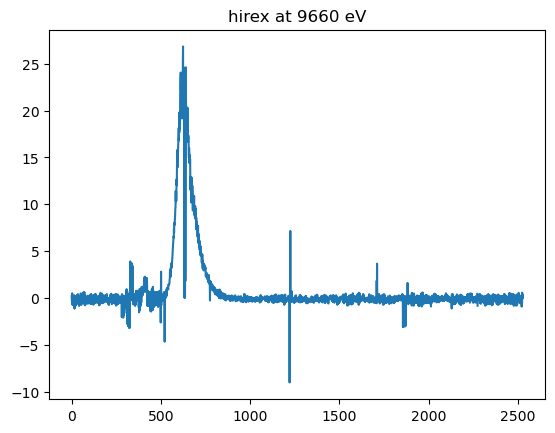

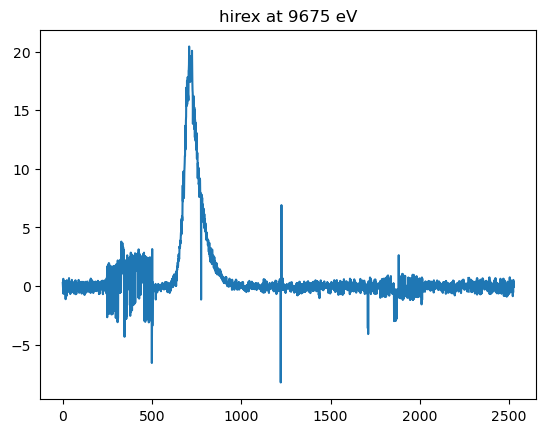

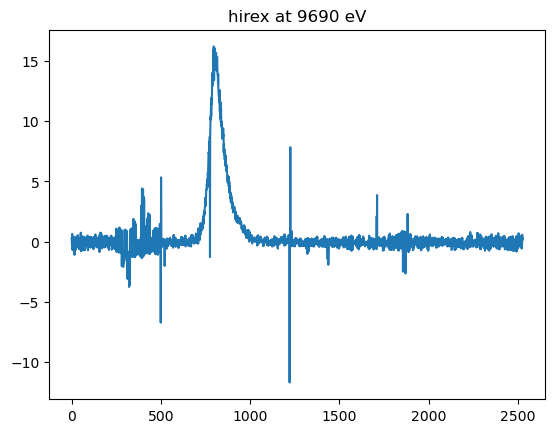

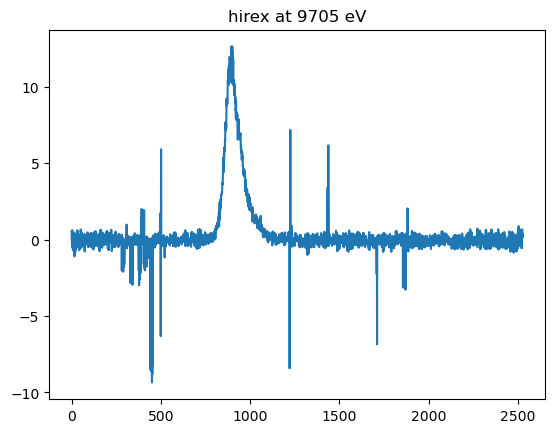

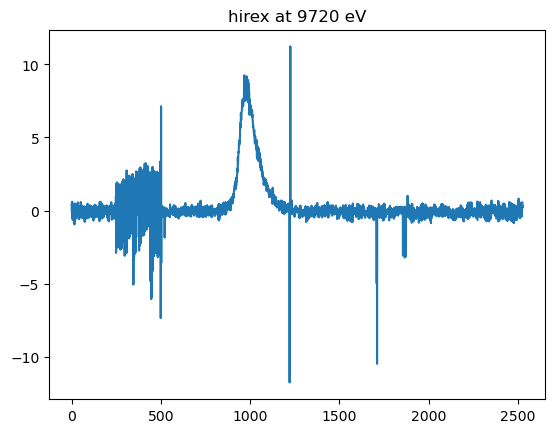

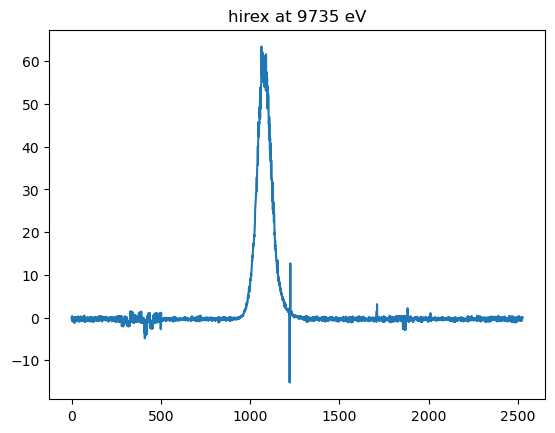

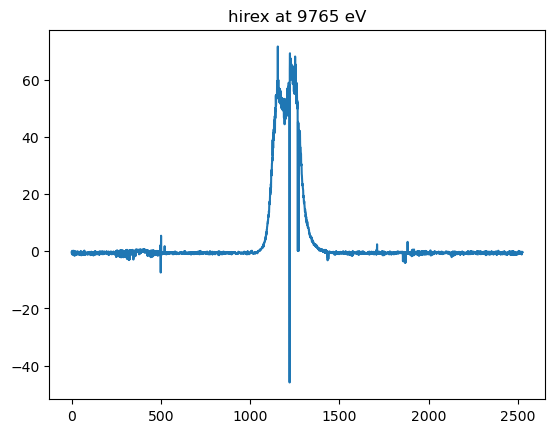

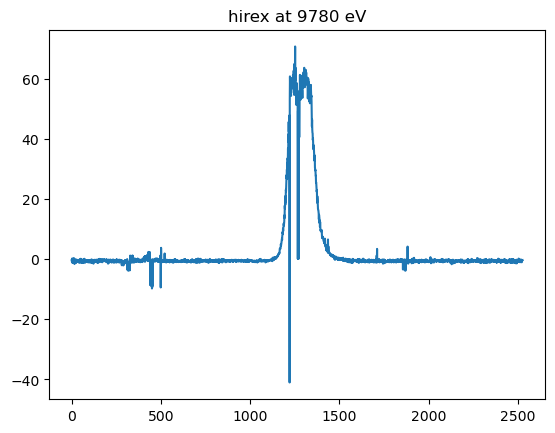

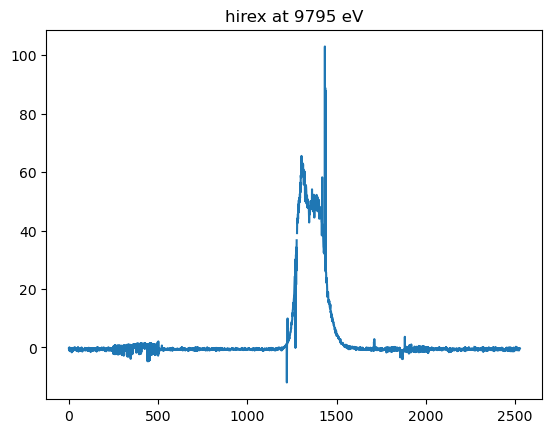

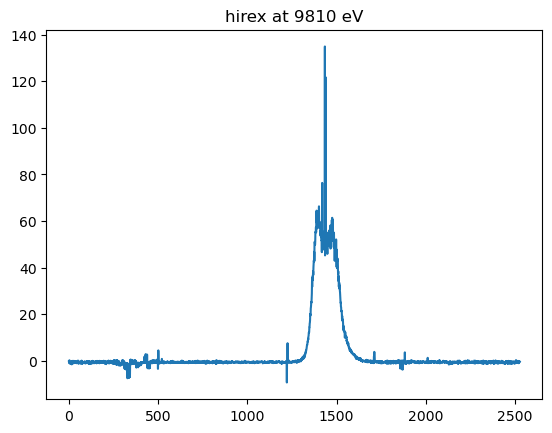

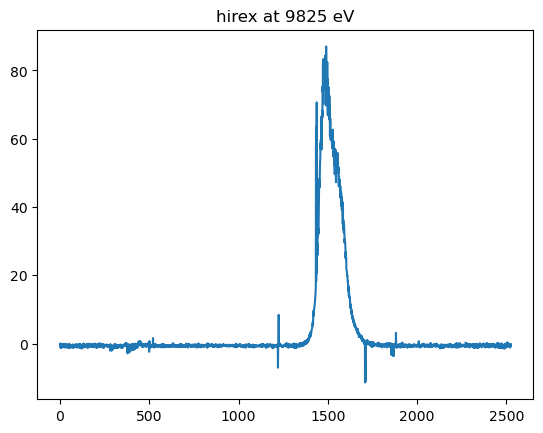

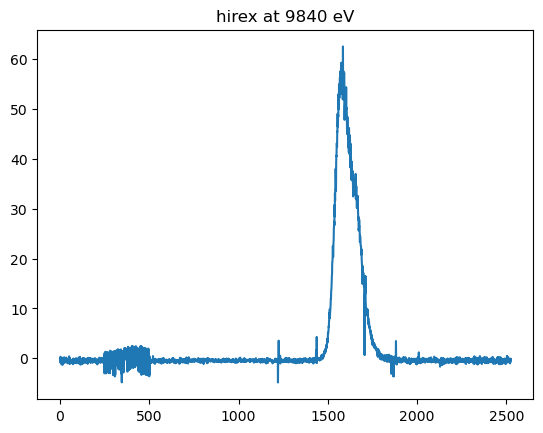

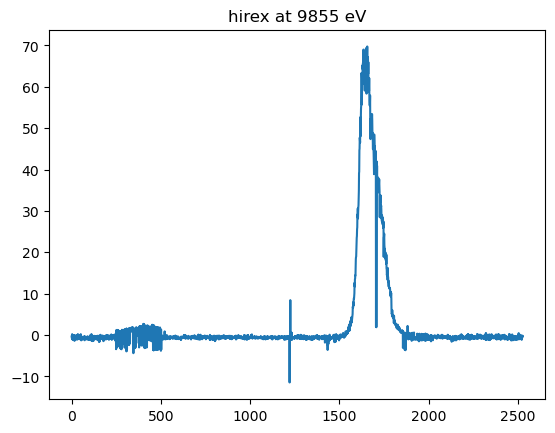

In [106]:
#new goal: write a function that for each energy of one run takes one train and calculates the mean spectrum. return this like {energ1: spectrum1, energy2:spectrum2, ...}
def mean_spectrum_train(train, mask=default_mask):
    skipped_first=False
    mean_spec=accumulators.Mean()
    data=train[1]
    spec_data=data[dh.det['hirex']]['data.adc']
    for index in range(np.shape(spec_data)[0]):
        curr_spec=spec_data[index,:]
        if spectrum_flag_df['flag'][index]:
            mean_spec.accumulate(curr_spec[mask])
    return mean_spec

def check_hirex_crystal_setting_run(run):
    #first get energies present in run
    df=dh.getPhotonEnergy_trainwise(run) #return dataframe
    #print(df)
    photon_energies=df['photon_energy'].unique()
    ret={}
    for ph_e in photon_energies:
        t_id=df.loc[df['photon_energy']==ph_e]['trainId'].iloc[len(df.loc[df['photon_energy']==ph_e]['trainId'])//2]
        #print(df.loc[df['photon_energy']==ph_e]['trainId'])
        ds = ex.open_run(proposal=dh.proposal, run=run)
        sel = ds.select(dh.det['hirex'])
        train = sel.train_from_id(t_id)
        ret[ph_e]=mean_spectrum_train(train)
    return ret

def check_hirex_crystal_setting_scan(scan):
    ret={}
    for run in scan:
        temp=check_hirex_crystal_setting_run(run)
        for energy in temp.keys():
            if energy in ret.keys():
                ret[energy].accumulate(temp[energy])
            else:
                ret[energy]=temp[energy]
    return ret

mean_spec_dict=check_hirex_crystal_setting_scan(np.arange(35, 62))
for energy in mean_spec_dict.keys():
    plt.plot(mean_spec_dict[energy])
    plt.title(f'hirex at {energy} eV')
    plt.show()

agipd not detected
hitfinder not detected
99.90% of the data of run 61 is used!


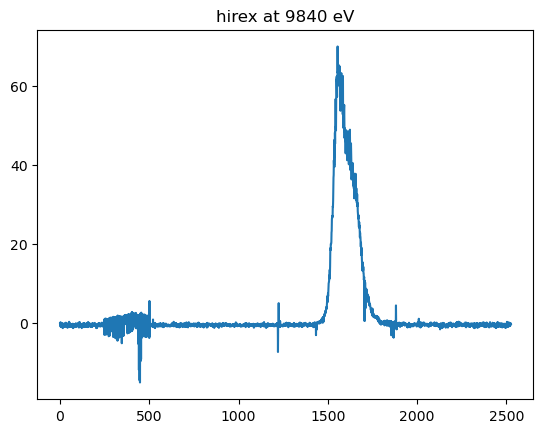

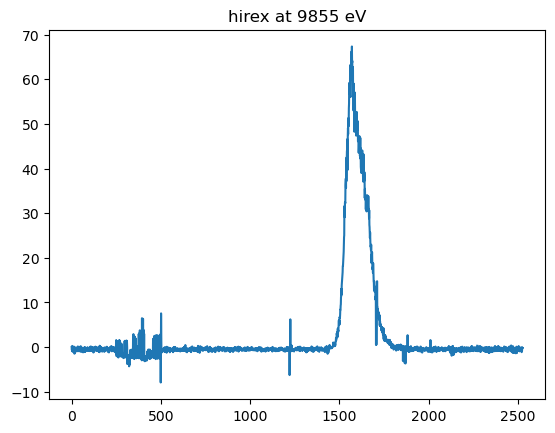

In [103]:
mean_spec_dict=check_hirex_crystal_setting_scan(np.arange(61, 62))
for energy in mean_spec_dict.keys():
    plt.plot(mean_spec_dict[energy])
    plt.title(f'hirex at {energy} eV')
    plt.show()

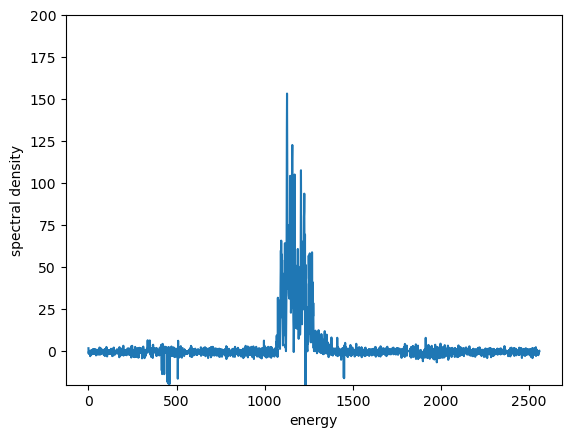

0 55
[ 0.321875   -0.00625    -2.0062501  ... -2.0001953  -0.0078125
  0.33964846]


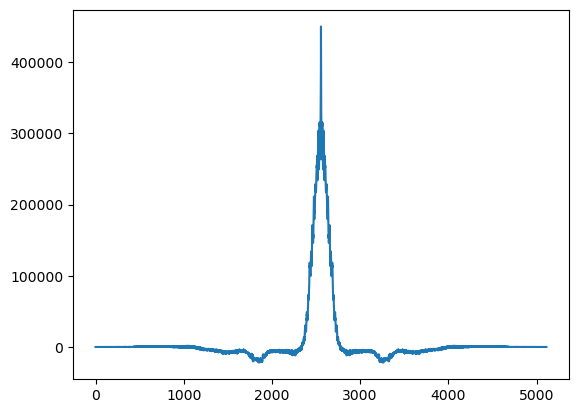

In [65]:
index=344  
#index=348
#index=352
line=np.copy(data[dh.det['hirex']]['data.adc'][index,:])
x=np.arange(len(line))
line[~default_mask]=0
plt.plot(x, line)
#plt.plot(x, scipy.ndimage.median_filter(line, size=5))
plt.xlabel('energy')
plt.ylabel('spectral density')
plt.ylim(-20,200)
plt.show()
check_for_spectrum(line)
plt.plot(autocorrelate(line))
print(autocorrelate(line))

In [55]:
np.where(line>25)

(array([ 317,  511,  673, 1121, 1234, 1236, 1455, 2304]),)

In [ ]:
plt.plot(auto)
plt.xlim(2535, 2575)
plt.title('run 34')
plt.xlabel('')

In [ ]:
data=next(trains_dh)[1]

In [93]:
n=0
skipped_first=False
df=pd.DataFrame()
df['flag']=np.zeros(1500)
for i in range(1500):
    line=np.copy(data[dh.det['hirex']]['data.adc'][i,:])
    if check_for_spectrum(line) and skipped_first:
        df['flag'][i]=1
        n+=1
    elif check_for_spectrum(line) and not skipped_first:
        skipped_first=True
print(n)    
df.to_csv('spectrum_flag_run8.csv')

351


In [ ]:
mask=line<-100
np.where(mask1!=0)

In [ ]:
index=20
roi_min=1000
roi_max=1500
x=np.arange(len(data[dh.det['hirex']]['data.adc'][index,:]))
plt.plot(x, data[dh.det['hirex']]['data.adc'][index,:])
plt.plot(x[roi_min:roi_max], data[dh.det['hirex']]['data.adc'][index,roi_min:roi_max])
plt.show()
plt.plot(hist.centers(),hist(data[dh.det['hirex']]['data.adc'][index,roi_min:roi_max]))
plt.yscale('log')

In [ ]:
data.keys()#['image.pulseId']/4

250

In [105]:
30*20*10/60

100.0